<a href="https://colab.research.google.com/github/erjank/563-a1/blob/main/debugging-mc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#Sampling, performance and system size
import numpy
directions = [numpy.array((1,0)),numpy.array((0,-1)),numpy.array((-1,0)),numpy.array((0,1))]
def pbc(site,L): #The convention here is to have positive lattice indices
  for i,s in enumerate(site):
    if s >= L:
      site[i] = s - L
    elif s < 0:
      site[i] = s + L
  return site

class grid():
  def __init__(self,N=5,L=4,T=1.0):
    self.L = L
    self.N = N
    self.epsilon = -1
    self.kT = T
    self.particles = []
    self.sites = numpy.zeros((L,L))
    for i in range(self.N):
      self.particles.append(particle())
      while True:
        rands = self.random_site()
        if not self.occupied(rands):
          self.particles[-1].location = rands
          self.sites[tuple(rands)] = 1 #occupied, will speed up neighbor list
          break
    self.E = self.energy()
    self.sanity_check()

  def occupied(self,site):
    if self.sites[tuple(site)] == 1:
      return True
    return False

  def sanity_check(self):
    if self.sites.sum() != self.N:
      print("sanity check failed")
      raise RuntimeError

  def random_site(self):
    return numpy.array((numpy.random.randint(self.L),numpy.random.randint(self.L)))

  def energy(self):
    self.sanity_check()
    energy = 0
    for p in self.particles:
      neighbors = p.get_neighbors(self.L)
      for n in neighbors:
        if self.occupied(n):
          energy += self.epsilon
    return energy/2

  def __repr__(self):
    m = numpy.zeros((self.L, self.L))
    for p in self.particles:
      m[tuple(p.location)] = 1
    return str(m)

class particle():
  def __init__(self):
    self.location = numpy.array((-1,-1)) #negative index means unplaced

  def get_neighbors(self,L):
    neighbors = []
    for d in directions:
      neighbors.append( pbc(d+self.location, L))
    return neighbors

  def local_energy(self,grid):
    neighbors = self.get_neighbors(grid.L)
    energy = 0
    for n in neighbors:
      if grid.occupied(n):
        energy += grid.epsilon
    return energy

class simulation():
  def __init__(self,N=5,L=3,T=1.,steps = 1000,seed=2,debug=False):
    numpy.random.seed(seed)
    self.grid = grid(N,L,T)
    self.accepted = 0
    self.rejected = 0
    self.energies = numpy.zeros(steps)
    for i in range(steps):
      self.trial_move()
      self.energies[i] = self.grid.E/N
      if debug:
        print("E:", self.grid.E)
        print(self.grid.sites)

  def move(self,particle,site): #use this to move particles, and back
    self.grid.sites[tuple(particle.location)] = 0
    particle.location = site
    self.grid.sites[tuple(site)] = 1

  def trial_move(self):
    self.grid.sanity_check()
    p = numpy.random.choice(self.grid.particles)
    old = p.location
    oldE = p.local_energy(self.grid) # only look at moved particle
    trial = self.grid.random_site()
    if not self.grid.occupied(trial):
      self.move(p,trial)
      newE = p.local_energy(self.grid)
      dE = newE - oldE
      if numpy.random.rand() < numpy.exp(-dE/self.grid.kT):
        self.grid.E += dE
        self.accepted += 1
        return
    self.move(p,old)
    self.rejected += 1


In [32]:
  s = simulation(N=10,L=4,T=1.0,steps=5, seed = 5,debug=True)

E: -13.0
[[1. 1. 1. 1.]
 [0. 0. 0. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]]
E: -13.0
[[1. 1. 1. 1.]
 [0. 0. 0. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]]
E: -13.0
[[1. 1. 1. 1.]
 [0. 0. 0. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]]
E: -13.0
[[1. 1. 1. 1.]
 [0. 0. 0. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]]
E: -13.0
[[1. 1. 1. 1.]
 [0. 0. 0. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]]


In [35]:
# Let's try out the first 5 exact solutions - the 3rd might be getting a little slow.
import time
answers = []
nsteps = 50000
for L in [3,5,10,15,20,25]:
  N = round(L*L*0.8)
  t1 = time.perf_counter()
  s = simulation(N=N,L=L,T=1.0,steps=nsteps, seed = numpy.random.randint(10000))
  t2 = time.perf_counter()
  print("\nN=",N,"; {:.2f} seconds/sim".format(t2-t1))
  answers.append( (s.energies.mean(), s.energies.std()))
  print("N=",N,"average E: {:.2f} +/- {:.2f}" .format( answers[-1][0],answers[-1][1]))
# OK, with the sped up code we're getting  worst case 1000 steps per second. not bad!


N= 7 ; 5.72 seconds/sim
N= 7 average E: -1.53 +/- 0.06

N= 20 ; 6.50 seconds/sim
N= 20 average E: -1.64 +/- 0.05

N= 80 ; 12.53 seconds/sim
N= 80 average E: -1.67 +/- 0.03

N= 180 ; 21.39 seconds/sim
N= 180 average E: -1.68 +/- 0.02

N= 320 ; 33.96 seconds/sim
N= 320 average E: -1.67 +/- 0.02

N= 500 ; 55.44 seconds/sim
N= 500 average E: -1.68 +/- 0.01


In [36]:
L = 30
N = round(L*L*0.8)
t1 = time.perf_counter()
s = simulation(N=N,L=L,T=1.0,steps=nsteps, seed = numpy.random.randint(10000))
t2 = time.perf_counter()
print("\nN=",N,"; {:.2f} seconds/sim".format(t2-t1))
answers.append( (s.energies.mean(), s.energies.std()))
print("N=",N,"average E: {:.2f} +/- {:.2f}" .format( answers[-1][0],answers[-1][1]))



N= 720 ; 71.45 seconds/sim
N= 720 average E: -1.68 +/- 0.02


In [37]:
L = 50
N = round(L*L*0.8)
t1 = time.perf_counter()
s = simulation(N=N,L=L,T=1.0,steps=nsteps, seed = numpy.random.randint(10000))
t2 = time.perf_counter()
print("\nN=",N,"; {:.2f} seconds/sim".format(t2-t1))
answers.append( (s.energies.mean(), s.energies.std()))
print("N=",N,"average E: {:.2f} +/- {:.2f}" .format( answers[-1][0],answers[-1][1]))



N= 2000 ; 190.19 seconds/sim
N= 2000 average E: -1.67 +/- 0.02


N= 80 average E: -1.89 +/- 0.00
N= 80 acceptance rate 0.00


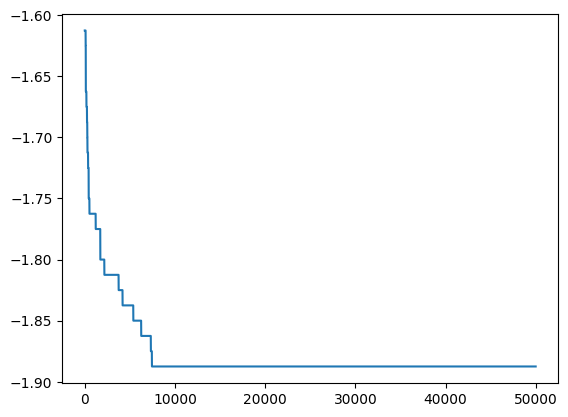

In [38]:
# Part 3, 5
import matplotlib.pyplot as plt
nsteps = 50000
s = simulation(N=80,L=10,T=0.05,steps=nsteps, seed = 27)
plt.plot(s.energies)
print("N=",80,"average E: {:.2f} +/- {:.2f}" .format(s.energies[-200:].mean(),s.energies[-200:].std()))
print("N=",80,"acceptance rate {:.2f}".format(s.accepted/nsteps))
# Here we can't just average the whole run- The equilibrium distribution here is
# flat- can take the last 200 steps or so.
# For this particular run we got to -1.89 +/- 0.00,

N= 80 average E: -1.66 +/- 0.03
N= 80 acceptance rate 0.12


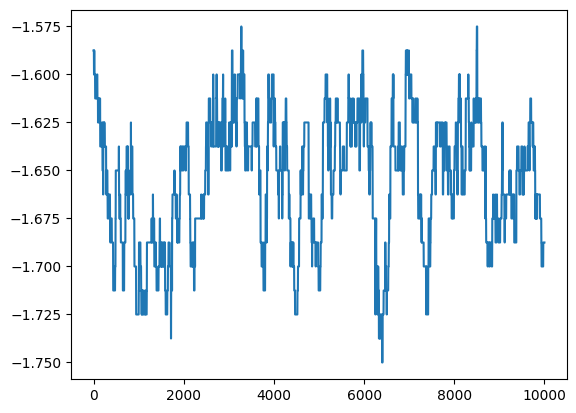

In [39]:
# Part 5
import matplotlib.pyplot as plt
nsteps = 10000
s = simulation(N=80,L=10,T=1.0,steps=nsteps, seed = 10)
plt.plot(s.energies)
print("N=",80,"average E: {:.2f} +/- {:.2f}" .format(s.energies.mean(),s.energies.std()))
print("N=",80,"acceptance rate {:.2f}".format(s.accepted/nsteps))
# Ok, so the acceptance rate is 12% for T=1.0, and more like 1% for T=0.05
# One thing we see from this run is that we've got a lower average than before-
# This includes the 1.64 from the N=20 run from before- this tells us that maybe
# we need to be running longer, or maybe we can get away with N=20 at T=1.0.
# So let's answer this when we revisit problem 4 below- let's sweep over a bunch
# of system sizes from N=20-100 for longer jobs and have a look at the distributions
# we get:

In [40]:
#Part 4, 2
import time
nsteps = 100000
results = {}
for L in range(3,15):
  N = round(L*L*0.8)
  t1 = time.perf_counter()
  s = simulation(N=N,L=L,T=1.0,steps=nsteps, seed = numpy.random.randint(400))
  t2 = time.perf_counter()
  results[N] = (t2-t1, s.energies, s.accepted/nsteps)
  print("N=",N,"average E: {:.2f} +/- {:.2f}" .format(s.energies.mean(), s.energies.std()))

N= 7 average E: -1.53 +/- 0.06
N= 13 average E: -1.64 +/- 0.05
N= 20 average E: -1.64 +/- 0.05
N= 29 average E: -1.66 +/- 0.05
N= 39 average E: -1.65 +/- 0.05
N= 51 average E: -1.66 +/- 0.04
N= 65 average E: -1.67 +/- 0.04
N= 80 average E: -1.67 +/- 0.03
N= 97 average E: -1.67 +/- 0.03
N= 115 average E: -1.67 +/- 0.03
N= 135 average E: -1.67 +/- 0.02


runtime for N= 180 243.36166985399905


-1.617501805555555

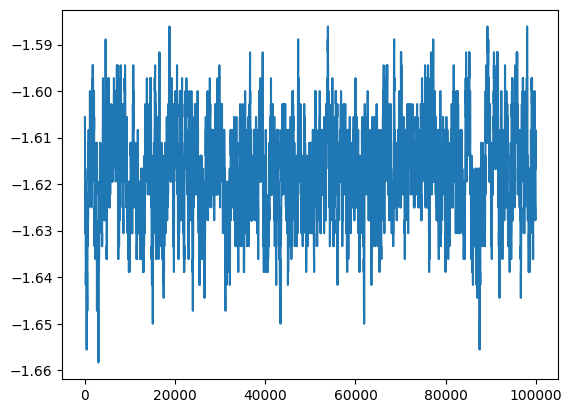

In [ ]:
# can play with results[7], results[65][1], etc to get the results from N=7, or the energies
# from N=65, respectively.
N = round(15*15*.8)
plt.plot(results[N][1])
print("runtime for N=",N, results[N][0])
results[N][1].mean()

## Problem 1
**What is the average energy-per-particle for this system at a temperature of 1.0 energy units and a number density N/V=0.8?**

Note: The energy was already normalized at ``self.energies[i] = self.grid.E/N`` in the ``simulation`` constructor ``__init__()`` function, so lots of folks normalized by an extra ``N``.

**Answer:** Around -1.68. Depending on which system sizes you used and how long you ran, you might see some variance around this.   

## Problem 2
**How precise is your measurement, and is there an N below which you lose confidence in your answer?**

**Answer:** Well this is a little tricky, because it depends on running sufficiently long and sufficiently large to **gain** confidence in what the right answer is.

From the samples above with ``nsteps=100000``:
```
N= 7 average E: -1.53 +/- 0.06
N= 13 average E: -1.64 +/- 0.05
N= 20 average E: -1.64 +/- 0.05
N= 29 average E: -1.66 +/- 0.05
N= 39 average E: -1.65 +/- 0.05
N= 51 average E: -1.66 +/- 0.04
N= 65 average E: -1.67 +/- 0.04
N= 80 average E: -1.67 +/- 0.03
N= 97 average E: -1.67 +/- 0.03
N= 115 average E: -1.67 +/- 0.03
N= 135 average E: -1.67 +/- 0.02
```
it's really looking like ``<E> = -1.67 +/- 0.03``. So, below ``N=13`` is where I'd **definitely** lose confidence, and here around ``N=65`` is a size above which it's not clear that additional accuracy is gained.

## Problem 3
**What is the average energy-per-particle at a temperature of 0.05?**

**Answer:** The tricky part here is that this is such a low temperature that the system gets stuck in local energy minima. What we'll see across different random initial conditions is that we'll generally get slightly different answers. However, all the answers will have zero fluctuations once it finds a local minimum around -1.89. Therefore the fluctuations here are zero.

Including higher-energy configurations in this sampling is a very common mistake.

This gets us thinking more generally about: What samples *can* I include in my averages?

## Problem 4
**What's the optimal system size for finding average energies?**

**Answer:** The smallest size that doesn't give a statistically different answer than the sizes below which we're confident in. Based on the data collected above, ``N=13`` is the most efficienty system size for quickly getting some ballpark average energies. We'll know that we might be off in the second decimal place by a digit or 4, but even with ``N=80`` our precision in the 2nd decimal is a digit or 2.

## Problem 5
**What is the trial move acceptance rate at T=1.0 and T= 0.05?**

**Answer:** Depending on your random number generator seed, whether you used the template code, and how long you run, in the ballpark of 20\% and 1\% for T=1 and T=0.05, respectively. If you run lunger at T=0.05, the acceptance rate will drop as more and more energy-increasing moves are attempted and rejected because the probabilities are diminishingly small.


## Overall takeaways:

* Small data structure changes (adding the sites to look up neighbors) can give huge performance benefits, and if our code is too slow we won't be able to answer some of these statistical questions like "How big is big enough?"
* We need to run longer to see if the results change, and this will often be *even* longer at lower T's
* Relatively small system sizes (here, N=20-90) can be totally sufficient for sampling.







